In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Annual Report**

In [ ]:
!tar -xf '/content/drive/MyDrive/NLP/fns2020_dataset.tar.gz'

In [ ]:
!tar -xf '/content/training.tar.gz'
!tar -xf '/content/validation.tar.gz'

# **Importing modules**

In [ ]:
# Import necessary libraries from the Natural Language Toolkit (nltk) for text processing.
import nltk
import os
import re
import math
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize

# Import pandas for data manipulation and analysis
import pandas as pd
import numpy as np
# Download essential nltk modules for text processing
nltk.download('averaged_perceptron_tagger')  # Part-of-speech tagging
nltk.download('stopwords') # Common English stopwords
nltk.download('punkt') # Tokenizer
nltk.download('wordnet') # Lexical database for English words

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Import the 'words' corpus from nltk, which contains a list of English words
from nltk.corpus import words

# Download the 'words' corpus if not already present in the nltk data directory
nltk.download('words')

# Create an instance of WordNetLemmatizer from nltk for lemmatization of words
lt = WordNetLemmatizer()

# Create a set of English stopwords using nltk's stopwords corpus
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
#Spacy for sentence tokenization
!pip install spacy
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
!pip install scikit-fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=63871bd2054f61bb0b537f5d6e0ee86d759c954d73d3699b1ccc284f4944c8ac
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


# **Data Exploration**

In [ ]:
"""traversing the training and testing datasets to calculate the number of annual reports and the """
import os
import random
annual_report_path1 = '/content/training/annual_reports'
summary_path1 = '/content/training/gold_summaries'
annual_report_path2 = '/content/validation/annual_reports'
summary_path2 = '/content/validation/gold_summaries'
c11 = os.listdir(annual_report_path1)
c12 = os.listdir(summary_path1)
c21 = os.listdir(annual_report_path2)
c22 = os.listdir(summary_path2)
print("The no of annual reports: Training: "+str(len(c11))+", Validation: "+str(len(c21)))
print("The no of gold summeries: Training: "+str(len(c12))+", Validation: "+str(len(c22)))
count1 = []
count2 = []
for ar in c11:
  t = 0
  x = ar.split('.')
  for gs in c12:
    y = gs.split('_')
    if x[0] == y[0]:
      t += 1
  count1.append(t)
for ar in c21:
  t = 0
  x = ar.split('.')
  for gs in c22:
    y = gs.split('_')
    if x[0] == y[0]:
      t += 1
  count2.append(t)
print("The no of gold summeries per annual report in Training folder: max- "+str(min(count1))+", max- "+str(max(count1)))
print("The no of gold summeries per annual report in Validation folder: max- "+str(min(count2))+", max- "+str(max(count2)))

The no of annual reports: Training: 3000, Validation: 363
The no of gold summeries: Training: 9873, Validation: 1250
The no of gold summeries per annual report in Training folder: max- 3, max- 7
The no of gold summeries per annual report in Validation folder: max- 3, max- 6


# **Preprocessing**

In [ ]:
#Extracting sentences from textfile

def get_sentences(text):
  """ using spacy to split textfile into sentences"""
  try:
    sentences = []
    doc = nlp(text)
    for sent in doc.sents:
      sentences.append(sent.text)
    return sentences
  except:
    return sent_tokenize(text)

**Example**: sentence tokenization using NLTK.punkt and spacy

In [ ]:
ar_file = open('/content/training/annual_reports/10023.txt', 'r')
ar_text = ar_file.read()
sentences_punkt = sent_tokenize(ar_text)
sentences_spacy = get_sentences(ar_text)
print("punkt ------------------------------------------")
print(sentences_punkt[1])
print('\n\n')
print("spacy ------------------------------------------")
print(sentences_spacy[12])
print(sentences_spacy[13])

punkt ------------------------------------------
“ The work undertaken over the past 12 months has 
significantly strengthened the Group’s technical and 
commercial position in the Mediterranean.” 
 Dr. Bill Higgs, Chief Executive 02
Mediterranean Oil & Gas Plc Annual Report 2011 www.medoilgas.com
BUILDING A RESOURCE 
FACTORY
ACQUISITIONS
DEVELOPMENT
PRODUCTION
EXPLORATION
MOG owns and operates 
assets in the central 
Mediterranean region.



spacy ------------------------------------------
“ The work undertaken over the past 12 months has 
significantly strengthened the Group’s technical and 
commercial position in the Mediterranean.” 
 
Dr. Bill Higgs, Chief Executive 02
Mediterranean Oil & Gas Plc Annual Report 2011 www.medoilgas.com
BUILDING A RESOURCE 
FACTORY
ACQUISITIONS
DEVELOPMENT
PRODUCTION
EXPLORATION
MOG owns and operates 
assets in the central 
Mediterranean region.



In [ ]:
#Removing sentences of length 3 or less
def remove_short_sentences(Sentences):
  """input: a list of sentences
     output: a list of sentences, each of length more than 3 words"""
  temp_sent = []
  for sent in Sentences:
    words = word_tokenize(sent)
    if len(words) > 3:
      temp_sent.append(sent)
  return temp_sent

In [ ]:
#remove web addresses
def remove_addresses_sent(text):
  clean_text = re.sub(r"\S*www.\S+", "", text)
  clean_text = re.sub(r"\S*WWW.\S+", "", clean_text)
  clean_text = re.sub(r"\S*.com\S+", "", clean_text)
  clean_text = re.sub(r"\S*.co\S+", "", clean_text)
  clean_text = re.sub(r"\S*.COM\S+", "", clean_text)
  clean_text = re.sub(r"\S*.gov\S+", "", clean_text)
  clean_text = re.sub(r"\S*.biz\S+", "", clean_text)
  clean_text = re.sub(r"\S*.org\S+", "", clean_text)
  return clean_text

def remove_addresses(sentences):
  for i in range(len(sentences)):
    sentences[i] = remove_addresses_sent(sentences[i])
  return sentences

**Example**

In [ ]:
print("Example text before web address removal -------------------------------------------")
print(sentences_punkt[1])
print("\nExample text after web address removal -------------------------------------------")
print(remove_addresses(sentences_punkt[1]))

Example text before web address removal -------------------------------------------
“ The work undertaken over the past 12 months has 
significantly strengthened the Group’s technical and 
commercial position in the Mediterranean.” 
 Dr. Bill Higgs, Chief Executive 02
Mediterranean Oil & Gas Plc Annual Report 2011 www.medoilgas.com
BUILDING A RESOURCE 
FACTORY
ACQUISITIONS
DEVELOPMENT
PRODUCTION
EXPLORATION
MOG owns and operates 
assets in the central 
Mediterranean region.

Example text after web address removal -------------------------------------------
“ The work undertaken over the past 12 months has 
significantly strengthened the Group’s technical and 
commercial position in the Mediterranean.” 
 Dr. Bill Higgs, Chief Executive 02
Mediterranean Oil & Gas Plc Annual Report 2011 
BUILDING A RESOURCE 
FACTORY
ACQUISITIONS
DEVELOPMENT
PRODUCTION
EXPLORATION
MOG owns and operates 
assets in the central 
Mediterranean region.


In [ ]:
def remove_special_characters(sentences):
  temp_text = []
  for sent in sentences:
    temp = ''
    for char in sent:
      if char.isalnum() or char == ' ' or char == '\n':
        temp += char
    temp_text.append(temp)
  return temp_text

In [ ]:
def remove_numerical_values(sentences):
  temp_sent = []
  for sent in sentences:
    words = word_tokenize(sent)
    temp = ''
    for word in words:
      if word.isalpha():
        temp += word+' '
    temp_sent.append(temp)
  return temp_sent

**Example**

In [ ]:
sen = [sentences_spacy[106], sentences_spacy[107]]
print("Original sentences -----------------------------------------------------------")
for x in sen:
  print(x)
print("Sentences after removing special characters ----------------------------------")
for x in remove_special_characters(sen):
  print(x)
print("Sentences after removing numerical values ------------------------------------")
for x in remove_numerical_values(sen):
  print(x+'\n')

Original sentences -----------------------------------------------------------
Following the successful drilling of two 
exploration/appraisal wells in 2008, the 
completion of a well as an oil producer and 
the set-up of a tripod platform in preparation 
for the development phase, the Company 
applied for a production Concession (d 30 
B.C-MD) in December 2008.

On 23 June 2009, the FDP project received 
technical approval from the Italian Ministry 
of Economic Development (‘MED’). 

Sentences after removing special characters ----------------------------------
Following the successful drilling of two 
explorationappraisal wells in 2008 the 
completion of a well as an oil producer and 
the setup of a tripod platform in preparation 
for the development phase the Company 
applied for a production Concession d 30 
BCMD in December 2008

On 23 June 2009 the FDP project received 
technical approval from the Italian Ministry 
of Economic Development MED 

Sentences after removing numerical 

In [ ]:
#POS tagging, stop word removal, lemmatization
def preprocessing(sentences):
  """input: A list of sentences
     output: the sentences,  a list of lists with each list containing tuples of each words and POS tags"""
  cleaned_sentences = []
  all_sentences = []
  for i in range(len(sentences)):
    sent = sentences[i]
    words = word_tokenize(sent)
    temp = []
    for word in words:
      if word.isalpha():
        temp.append(word)
    if len(temp):
      tagged_words = nltk.pos_tag(temp)
      temp = []
      for tup in tagged_words:
        if tup[0] not in stop_words:
          tup = (lt.lemmatize(tup[0].lower()), tup[1])
          temp.append(tup)
    all_sentences.append(sent)
    cleaned_sentences.append(temp)

  return all_sentences, cleaned_sentences, len(all_sentences)

def tup_sent(cleaned_sentences):
  """input: a list of lists with each list containing tuples of each words and POS tags
     output: a list of strings with each string containing the words of corresponding list of tuples"""
  sentences = []
  for sent in cleaned_sentences:
    temp = ''
    for tup in sent:
      if len(temp) == 0:
        temp += tup[0]
      else:
        temp += ' '+tup[0]
    sentences.append(temp)
  return sentences

**Example**

In [ ]:
sents, pos_tups, n = preprocessing(sen)
final_sents = tup_sent(pos_tups)
print("Original sentences -----------------------------------------------------------")
for x in sents:
  print(x+'\n')
print("Sentences with POS tagging----------------------------------------------------")
for x in pos_tups:
  print(str(x)+'\n')
print("\nClean sentences -----------------------------------------------------------")
for x in final_sents:
  print(x+'\n')

Original sentences -----------------------------------------------------------
Following the successful drilling of two 
exploration/appraisal wells in 2008, the 
completion of a well as an oil producer and 
the set-up of a tripod platform in preparation 
for the development phase, the Company 
applied for a production Concession (d 30 
B.C-MD) in December 2008.


On 23 June 2009, the FDP project received 
technical approval from the Italian Ministry 
of Economic Development (‘MED’). 


Sentences with POS tagging----------------------------------------------------
[('following', 'VBG'), ('successful', 'JJ'), ('drilling', 'NN'), ('two', 'CD'), ('well', 'NNS'), ('completion', 'NN'), ('well', 'NN'), ('oil', 'NN'), ('producer', 'NN'), ('tripod', 'JJ'), ('platform', 'NN'), ('preparation', 'NN'), ('development', 'NN'), ('phase', 'VBD'), ('company', 'NNP'), ('applied', 'VBD'), ('production', 'NN'), ('concession', 'NNP'), ('december', 'NNP')]

[('on', 'IN'), ('june', 'NNP'), ('fdp', 'NNP'), ('

# **Feature Extraction**

In [ ]:
sents, pos_tups, n = preprocessing(sentences_spacy[120:140])
final_sents = tup_sent(pos_tups)
print('Example sentences --------------------------------------------------------')
for x in sents:
  print(x+'\n')
print('Sentence tokens with pos tags---------------------------------------------')
for x in pos_tups:
  print(x)
print('\n\nClean sentences ----------------------------------------------------------')
for x in final_sents:
  print(x+'\n')

Example sentences --------------------------------------------------------
12
Mediterranean Oil & Gas Plc Annual Report 2011 www.medoilgas.com
Chief Executive’s report continued
Since 2008, the Company has completed  
a detailed G&G assessment of the area, in 
order to de-risk the prospects and verify the 
presence of technically and commercially 
valuable exploration drilling opportunities. 


With this objective in mind, in late 2011 the 
Company acquired 1,012 sq km of high 
resolution long offset 3D seismic data on 
the most prospective sector of Area 4.

The 
Company believes that this 3D data will  
be fundamental to completing the G&G 
assessment and de-risking the exploration 
potential.

A comprehensive CPR has been 
commissioned.

The results of this study, 
which are expected early in the 3rd Quarter 
of 2012, will underpin the Company’s 
strategy to seek a farm-in partner  
and progress the exploration of this 
interesting acreage.


France
The St. Laurent permit is located

tf(word1) = frequency of word1 in the sentence/ total no of words in the sentence

isf(word1) = log(total no of sentences/ no of sentences containng word1 in document)

tf-isf(word1) = tf(word1)*isf(word1)

tf-isf(sentence) = sum of all tf-isf of the words

In [ ]:
#sent features: 1. tf-isf
def word_freq(sentences):
  """
  Input: A list of sentences (sentences).
  Output: A dictionary (word_dict) where keys are unique words in the sentences,
  and values are the frequency of each word in the entire set of sentences.
  """
  word_dict = {}
  for sent in sentences:
    words = list(set(word_tokenize(sent)))
    for word in words:
      if word not in word_dict:
        word_dict[word] = 1
      else:
        word_dict[word] += 1
  return word_dict

def tf_isf(sentences):
  """
  Input: A list of sentences (sentences).
  Output: A list containing the TF-ISF scores for each sentence.
  """
  word_dict = word_freq(sentences)
  n_sent = len(sentences)
  keys = word_dict.keys()
  tf_isf_score_pre_sentence = []

  for key in keys:
    x = word_dict[key]
    x = math.log(float(n_sent)/x)
    word_dict[key] = x

  for i in range(n_sent):
    sent_val = 0
    sent = sentences[i]
    temp = {}
    words = word_tokenize(sent)
    if len(words) == 0:
      tf_isf_score_pre_sentence.append(0)
    for word in words:
      if word not in temp:
        temp[word] = 1
      else:
        temp[word] += 1

    keys = temp.keys()
    for key in keys:
      tf = float(temp[key])/len(words)
      isf = word_dict[key]
      sent_val += (tf*isf)
    sent_val /= len(words)
    tf_isf_score_pre_sentence.append(sent_val)
  return tf_isf_score_pre_sentence

In [ ]:
tf_isf(final_sents)

[0.30243516251047153,
 0.3748310162881796,
 0.23959058207726158,
 0.37446653419424886,
 0.3178116803295496,
 0.3627358543310479,
 0.2652858827166921,
 0.3529879776680027,
 0.27619002474569654,
 0.31716902116153334,
 0.3893028246088282,
 0.2905480862259703,
 0.35606966461378264,
 0.3644831889333447,
 0.3342660348210648,
 0.29320745906468354,
 0.3395786312996825,
 0.30267780015069623,
 0.3381781484301394,
 0.31366813090385304]

In [ ]:
#sent features: 2. capital words
def capital_or_not(word):
  for i in range(len(word)):
    if word[i].isupper() == True and i != 0:
      return 1
  return 0

def Capital_letters(real_sentences):
  """
  Input: A list of sentences (sentences).
  Output: Normalized capital word score for each sentence
  """
  cp_score = []
  for sent in real_sentences:
    if len(sent) == 0:
      cp_score.append(0)
      continue
    temp = 0
    words = word_tokenize(sent)
    for word in words:
      if word.isalpha() and capital_or_not(word) == 1:
        if word.isupper():
          temp += 2
        else:
          temp += 1
    temp = float(temp)/len(words)
    cp_score.append(temp)
  max_val = max(cp_score)
  for i in range(len(cp_score)):
    cp_score[i] = float(cp_score[i])/max_val
  return cp_score

In [ ]:
Capital_letters(sents)

[0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6363636363636365,
 0.4666666666666667,
 0.0,
 0.0,
 0.2413793103448276,
 0.0,
 0.0,
 0.0,
 0.16279069767441862,
 0.411764705882353]

In [ ]:
#sent features: 3. similarity with other sentences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def similarity_sent(sentences):
  """
  Input: A list of sentences (sentences).
  Output: Normalized cosine similarity score for each sentence
  """
  sim_score_sent = []
  vectorizer = CountVectorizer().fit_transform(sentences) # CountVectorizer to convert sentences to a bag-of-words representation
  sim_matrix = cosine_similarity(vectorizer, vectorizer)
  for i in range(len(sentences)):
    x = sum(sim_matrix[i])/float(len(sim_matrix[0]))
    sim_score_sent.append(x)
  max_val = max(sim_score_sent)
  for i in range(len(sim_score_sent)):
    x = sim_score_sent[i]/max_val
    sim_score_sent[i] = 1 - x
  return sim_score_sent

In [ ]:
similarity_sent(final_sents)

[0.349903113735722,
 0.3642881128401467,
 0.0,
 0.7327982944386009,
 0.24095412028097485,
 0.405975555213528,
 0.01712893835032081,
 0.4173963726254787,
 0.28309269613031673,
 0.3298438584373843,
 0.6882646768450345,
 0.231604953825588,
 0.6913238050535118,
 0.4971878942202531,
 0.42786850630981244,
 0.37751757949387743,
 0.25033500438411116,
 0.30825752859514866,
 0.4194023376298912,
 0.35413315521640343]

In [ ]:
#sent features: 4. keywords
keywords = ['financial statement',
             'annual report',
             'growth',
             'audit committee',
             'executive director',
             'chairman',
             'stock',
             'shareholder',
             'stockholder',
             'dividend',
             'share',
             'acquisition',
             'year end',
             'this year',
             'annual report account',
             'board of directors',
             'million',
             'account',
             'production',
             'revenue',
             'company',
             'business',
             'plc',
             'profit']
keywords2 = ['cost',
             'result',
             'strategy',
             'service',
             'management']


def keyword_sent(sentences):
  """
  Input: A list of sentences (sentences).
  Output: Normalized key word score for each sentence
  """
  k_score_sent = []
  for sent in sentences:
    if len(sent) == 0:
      k_score_sent.append(0)
      continue
    score = 0
    words = word_tokenize(sent)
    for kw in keywords:
      if kw in sent:
        score += 1
    score = float(score)/len(words)
    k_score_sent.append(score)
  max_val = max(k_score_sent)
  for i in range(len(k_score_sent)):
    k_score_sent[i] = float(k_score_sent[i])/max_val
  return k_score_sent

In [ ]:
keyword_sent(final_sents)

[0.32142857142857145,
 0.17647058823529413,
 0.27272727272727276,
 0.0,
 0.6000000000000001,
 0.0,
 1.0,
 0.0,
 0.2,
 0.42857142857142855,
 0.0,
 0.6666666666666666,
 0.0,
 0.5454545454545455,
 0.21428571428571427,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
#sent features: 5. content words
def Content_word(cleaned_sentences):
  """
  Input: A list of sentences (sentences).
  Output: Normalized token word score for each sentence
  """
  noun_verb = ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
  adjective_adverb = ["JJ", "JJR", "JJS", "RB", "RBR", "RBS"]
  content_score_sent = []
  for sent in cleaned_sentences:
    if len(sent) == 0:
      content_score_sent.append(0)
      continue
    score = 0
    for tup in sent:
      if tup[1] in noun_verb:
        score += 2
      elif tup[1] in adjective_adverb:
        score += 1
    score = float(score) / len(sent)
    content_score_sent.append(score)
  max_val = max(content_score_sent)
  for i in range(len(content_score_sent)):
    content_score_sent[i] = float(content_score_sent[i])/max_val
  return content_score_sent

In [ ]:
Content_word(pos_tups)

[0.875,
 0.7352941176470589,
 0.8636363636363636,
 0.625,
 0.8666666666666667,
 0.875,
 0.6666666666666666,
 0.8529411764705882,
 0.8666666666666667,
 0.8571428571428571,
 1.0,
 0.8333333333333334,
 0.7857142857142857,
 0.7727272727272727,
 0.9285714285714286,
 0.9230769230769231,
 0.7352941176470589,
 0.875,
 0.8478260869565217,
 0.8333333333333334]

In [ ]:
def get_sent_features(text):
  """
  Input: Text file
  Output: The sentences and 5 features for each sentence
  """
  sentences = get_sentences(text)
  sentences = remove_short_sentences(sentences)
  sentences_0 = remove_addresses(sentences)
  sentences_1 =  remove_special_characters(sentences_0)
  sentences_2 =  remove_numerical_values(sentences_1)

  sent, tuples_sent, N = preprocessing(sentences_2)
  cleared_sent = tup_sent(tuples_sent)

  tfisf = tf_isf(cleared_sent)
  cap = Capital_letters(sent)
  sim = similarity_sent(cleared_sent)
  kw = keyword_sent(cleared_sent)
  cont = Content_word(tuples_sent)

  features = []
  for i in range(N):
    temp = [tfisf[i], cap[i], sim[i], kw[i], cont[i]]
    features.append(temp)
  return sentences, features, [tfisf, cap, sim, kw, cont]

In [ ]:
sents, feats, _ = get_sent_features(ar_text)
for i in range(10, 12):
  print(sents[i])
  print("Features: "+str(feats[i])+'\n')

Strategic growth opportunities will be pursued 
actively
Mediterranean Oil & Gas Plc (‘MOG’ or the ‘Company’) is 
an Aim listed oil & gas production, development and 
exploration company which owns and operates assets 
in the central Mediterranean region.

Features: [0.4304628319474851, 0.027777777777777776, 0.2675397237814324, 0.32, 0.94]

“ The work undertaken over the past 12 months has 
significantly strengthened the Group’s technical and 
commercial position in the Mediterranean.” 
 
Features: [0.4242524215832532, 0.0, 0.4936470492508891, 0.0, 0.7083333333333334]



# **Fuzzy Analysis**

In [ ]:
#file created by combining individual feature files for all training annual reports
file = pd.read_csv('/content/drive/MyDrive/NLP/training_data_feat_complete.csv')
file = file.iloc[:, 1:]
file = file.dropna()
file.head()

,Sentences,tfisf,capital,sent_similarity,keyword,content_words,class
0,Darty plc Annual report 2013/14\nAnnual repor...,0.365608,0.000000,0.450426,0.500000,0.916667,0
1,CONTENTS\nOverview\n01 Group at a glance\n02 ...,0.505029,0.090909,0.578855,0.166667,1.000000,0
2,Our markets\n05 Strategy\n06,1.260592,0.000000,0.866590,0.000000,0.666667,0
3,Our business model and strategy\n07 Chief exe...,0.038922,0.031579,0.063381,0.077922,0.954545,0
4,Shareholder information\n132 Group five-year s...,0.312055,0.000000,0.547423,0.250000,0.916667,0


In [ ]:
#unique values for each features
!unzip '/content/drive/MyDrive/NLP/unique_feats.zip'
df1 = pd.read_csv('/content/unique_feats/tfisf_unique.csv')
df1 =sorted(list(np.array(df1.iloc[:, 1])))
df2 = pd.read_csv('/content/unique_feats/capital_unique.csv')
df2 = sorted(list(np.array(df2.iloc[:, 1])))
df3 = pd.read_csv('/content/unique_feats/sent_similarity_unique.csv')
df3 = sorted(list(np.array(df3.iloc[:, 1])))
df4 = pd.read_csv('/content/unique_feats/keyword_unique.csv')
df4 = sorted(list(np.array(df4.iloc[:, 1])))
df5 = pd.read_csv('/content/unique_feats/content_words_unique.csv')
df5 = sorted(list(np.array(df5.iloc[:, 1])))

Archive:  /content/drive/MyDrive/NLP/unique_feats.zip
   creating: unique_feats/
  inflating: unique_feats/capital_unique.csv  
  inflating: unique_feats/content_words_unique.csv  
  inflating: unique_feats/keyword_unique.csv  
  inflating: unique_feats/sent_similarity_unique.csv  
  inflating: unique_feats/tfisf_unique.csv  


In [ ]:
#input variables for the fuzzy control system
tfisf_var = ctrl.Antecedent(df1, 'tfisf_var')
cap_var = ctrl.Antecedent(df2, 'cap_var')
sim_var = ctrl.Antecedent(df3, 'sim_var')
kw_var = ctrl.Antecedent(df4, 'kw_var')
cont_var = ctrl.Antecedent(df5, 'cont_var')

#ouput variable for the fuzzy control system
senten = ctrl.Consequent(np.arange(0, 100), 'senten')

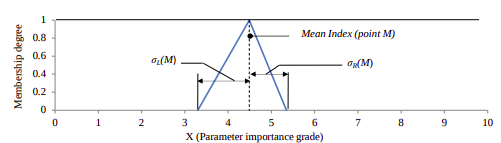

[link to the paper](https://doi.org/10.22115/scce.2017.48336)

In [ ]:
param = {}
for col in list(file.columns)[1:-1]:
  col_values = file[col]
  mean = np.mean(col_values)
  stdev = np.std(col_values)

  sorted_col_values = sorted(col_values)
  for i in range(len(sorted_col_values)):
    if sorted_col_values[i] == mean:
      start = i
      for j in range(i, len(sorted_col_values)):
        if sorted_col_values[j] > mean:
          break
      end = j
      break
    elif sorted_col_values[i] > mean:
      start = i
      end = i
      break
  L_M = np.sum(sorted_col_values[:end])
  R_M = np.sum(sorted_col_values[start:])
  S = L_M/float(R_M)

  sd_R = stdev/(1+S)
  sd_L = sd_R*S

  LL = mean - sd_L
  UL = mean + sd_R

  param[col] = [LL, mean, UL]

for key, value in param.items():
    print(key+": "+str(value))

tfisf: [0.2536065401119694, 0.451889034786618, 0.7418356339182273]
capital: [0.032327843324523646, 0.03584718414607536, 0.13846605432493106]
sent_similarity: [0.6053414174965925, 0.6728208678734243, 0.8016282437281385]
keyword: [0.0722868213327332, 0.08087860069935249, 0.2011177326738737]
content_words: [0.8051227029902677, 0.8495309264259594, 0.9164887501389241]


In [ ]:
tfisf_var['low'] = fuzz.trimf(tfisf_var.universe, [0, 0, param['tfisf'][1]])
tfisf_var['mid'] = fuzz.trimf(tfisf_var.universe, [param['tfisf'][0], param['tfisf'][1], param['tfisf'][2]])
tfisf_var['high'] = fuzz.trimf(tfisf_var.universe, [param['tfisf'][1], 9.962982124321767, 9.962982124321767])

cap_var['low'] = fuzz.trimf(cap_var.universe, [0, 0, param['capital'][1]])
cap_var['mid'] = fuzz.trimf(cap_var.universe, [param['capital'][0], param['capital'][1], param['capital'][2]])
cap_var['high'] = fuzz.trimf(cap_var.universe, [param['capital'][1], 1.0, 1.0])

sim_var['low'] = fuzz.trimf(sim_var.universe, [0, 0, param['sent_similarity'][1]])
sim_var['mid'] = fuzz.trimf(sim_var.universe, [param['sent_similarity'][0], param['sent_similarity'][1], param['sent_similarity'][2]])
sim_var['high'] = fuzz.trimf(sim_var.universe, [param['sent_similarity'][1], 1.0, 1.0])

kw_var['low'] = fuzz.trimf(kw_var.universe, [0, 0, param['keyword'][1]])
kw_var['mid'] = fuzz.trimf(kw_var.universe, [param['keyword'][0], param['keyword'][1], param['keyword'][2]])
kw_var['high'] = fuzz.trimf(kw_var.universe, [param['keyword'][1], 1.0, 1.0])

cont_var['low'] = fuzz.trimf(cont_var.universe, [0, 0, param['content_words'][1]])
cont_var['mid'] = fuzz.trimf(cont_var.universe, [param['content_words'][0], param['content_words'][1], param['content_words'][2]])
cont_var['high'] = fuzz.trimf(cont_var.universe, [param['content_words'][1], 1.0, 1.0])

senten['very bad'] = fuzz.trimf(senten.universe, [0, 0, 25])
senten['bad'] = fuzz.trimf(senten.universe, [0, 25, 50])
senten['avg'] = fuzz.trimf(senten.universe, [25, 50, 75])
senten['good'] = fuzz.trimf(senten.universe, [50, 75, 100])
senten['best'] = fuzz.trimf(senten.universe, [75, 100, 100])

In [ ]:
rule1 = ctrl.Rule(sim_var['low'], senten['very bad'])
rule2 = ctrl.Rule(sim_var['mid'] & (cont_var['high'] | cont_var['mid']), senten['bad'])
rule3 = ctrl.Rule(sim_var['high'] & (cont_var['high'] | cont_var['mid']), senten['avg'])
rule4 = ctrl.Rule(sim_var['mid'] & cont_var['low'], senten['avg'])
rule5 = ctrl.Rule(sim_var['high'] & cont_var['low'], senten['good'])
rule6 = ctrl.Rule(tfisf_var['high'], senten['best'])
rule7 = ctrl.Rule(tfisf_var['mid'] & cont_var['low'], senten['good'])
rule8 = ctrl.Rule(tfisf_var['low'], senten['very bad'])
rule9 = ctrl.Rule(tfisf_var['mid'] & (cont_var['high'] | cont_var['mid']), senten['avg'])

In [ ]:
sent_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
Sent = ctrl.ControlSystemSimulation(sent_ctrl)

In [ ]:
def find_summary_sentences(scores, n):
  import copy
  temp = sorted(list(set(copy.copy(scores))), reverse=True)
  if n < len(temp):
    temp = temp[:n]
  temp2 = []
  for x in temp:
    temp2.append((x[1], x[0]))
  return len(temp2), sorted(temp2)

In [ ]:
def find_summary(file, n):
  summary=[]
  scores1 = []
  scores2 = []
  for i in range(len(file)):
    Sent.input['tfisf_var'] = file.iloc[i, 2]
    Sent.input['sim_var'] = file.iloc[i, 4]
    Sent.input['cont_var'] = file.iloc[i, 6]
    Sent.compute()
    x = Sent.output['senten']
    #Sent.print_state()
    if x >= 75:
      scores1.append((x, i))
    elif x >= 50 and x < 75:
      scores2.append((x, i))
  n1, first = find_summary_sentences(scores1, n)
  if n1 != n:
    n2, second = find_summary_sentences(scores2, n-n1)
    first.extend(second)
  index = sorted(first)
  for x in index:
      summary.append(file.iloc[x[0], 1])
  for i in range(len(summary)):
    x = summary[i]
    if type(x) == 'str':
      x = x.replace('\n', ' ')
    summary[i] = str(x)
  return summary

In [ ]:
!unzip '/content/drive/MyDrive/NLP/validation_features.zip'

Archive:  /content/drive/MyDrive/NLP/validation_features.zip
   creating: validation_features/
  inflating: validation_features/31127.csv  
  inflating: validation_features/32144.csv  
  inflating: validation_features/32809.csv  
  inflating: validation_features/31646.csv  
  inflating: validation_features/32140.csv  
  inflating: validation_features/32157.csv  
  inflating: validation_features/32143.csv  
  inflating: validation_features/32562.csv  
  inflating: validation_features/32553.csv  
  inflating: validation_features/30874.csv  
  inflating: validation_features/32773.csv  
  inflating: validation_features/30947.csv  
  inflating: validation_features/31568.csv  
  inflating: validation_features/31632.csv  
  inflating: validation_features/31811.csv  
  inflating: validation_features/32034.csv  
  inflating: validation_features/30952.csv  
  inflating: validation_features/31938.csv  
  inflating: validation_features/30821.csv  
  inflating: validation_features/31942.csv  
  inf

In [ ]:
path = '/content/validation_features'
cont = os.listdir(path)
ll = '/content/drive/MyDrive/NLP/system_summary'
contt = os.listdir(ll)
for x in contt:
  y = x.split('_')[0] + '.csv'
  cont.remove(y)
i = 0
for x in cont:
 try:
  pt_fl = os.path.join(path, x)
  df = pd.read_csv(pt_fl)
  lines = find_summary(df, 50)
  name = x.split('.')[0]+'_system1.txt'
  fl = open('/content/drive/MyDrive/NLP/system_summary/'+name, 'w')
  for line in lines:
    fl.write(line+'\n')
  fl.close()
  print(len(cont)-i)
  i += 1
 except:
  print("ERROR: "+x)

In [ ]:
path = '/content/validation_features'
cont = ['31631.csv']
for x in cont:
  pt_fl = os.path.join(path, x)
  df = pd.read_csv(pt_fl)
  lines = find_summary(df, 50)
  name = x.split('.')[0]+'_system1.txt'
  fl = open('/content/drive/MyDrive/NLP/system_summary/'+name, 'w')
  for line in lines:
    fl.write(line+'\n')
  fl.close()
  print(len(cont)-i)
  i += 1

1
